# Count Total Number of VADs collected

In [6]:
import pandas as pd
total_count=0
for d in [20220517,20220519,20220523,20220524,20220530,20220531,20220605,20220606,20220607,20220609,20220611,20220612]:
    day_count=0
    for r in ['Ka1','Ka2']:
        try:
            df = pd.read_csv(f'C:\\Users\\Field5\\Documents\\{d}_{r}_scan_log.txt')
            day_count += df['Scantype'].value_counts()['vad']
            total_count += df['Scantype'].value_counts()['vad']
        except: pass
    print(f'{d}: {day_count}')
print(f'Total number of VADs: {total_count}')


20220517: 207
20220519: 806
20220523: 331
20220524: 371
20220530: 395
20220531: 336
20220605: 88
20220606: 488
20220607: 439
20220609: 301
20220611: 192
20220612: 593
Total number of VADs: 4547


155 40 62 50 307
176 8 36 105 325


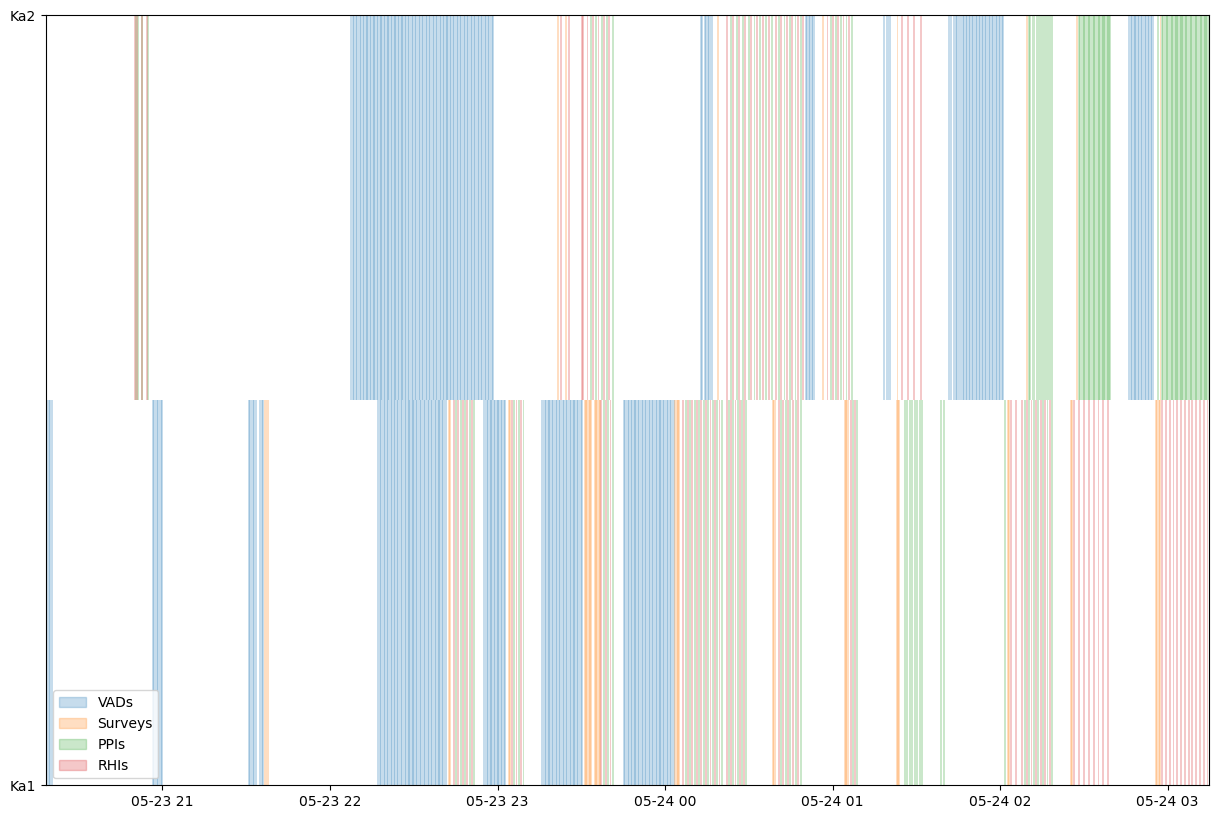

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(15,10))

d=20220523
pwd = '/lustre/work/aschueth'
df1 = pd.read_csv(f'{pwd}/{d}/Ka1/{d}_Ka1_scan_log.txt')
df2 = pd.read_csv(f'{pwd}/{d}/Ka2/{d}_Ka2_scan_log.txt')

begin_time = np.minimum(datetime.strptime(df1.Datetime[0],'%Y-%m-%d %H:%M:%S'),datetime.strptime(df2.Datetime[0],'%Y-%m-%d %H:%M:%S'))
end_time = np.maximum(datetime.strptime(df1.Datetime[len(df1)-1],'%Y-%m-%d %H:%M:%S'),datetime.strptime(df2.Datetime[len(df2)-1],'%Y-%m-%d %H:%M:%S'))
grid = np.zeros((2,int((end_time-begin_time).seconds+1)))
grid = np.where(grid==0,np.nan,np.nan)

for i,r in enumerate(['Ka1','Ka2']):
    df = pd.read_csv(f'{pwd}/{d}/{r}/{d}_{r}_scan_log.txt')
    vad = df['Scantype'].value_counts()['vad']
    survey = df['Scantype'].value_counts()['survey']
    rhi = df['Scantype'].value_counts()['rhi']
    ppi = df['Scantype'].value_counts()['ppi']
    print(vad,survey,rhi,ppi,vad+survey+rhi+ppi)

    vad_df = df.where(df['Scantype']=='vad').dropna(axis = 0, how = 'all')
    survey_df = df.where(df['Scantype']=='survey').dropna(axis = 0, how = 'all')
    ppi_df = df.where(df['Scantype']=='ppi').dropna(axis = 0, how = 'all')
    rhi_df = df.where(df['Scantype']=='rhi').dropna(axis = 0, how = 'all')

    for t in vad_df.Datetime:
        ax.axvspan(datetime.strptime(t,'%Y-%m-%d %H:%M:%S')-timedelta(seconds=20),datetime.strptime(t,'%Y-%m-%d %H:%M:%S')+timedelta(seconds=20), facecolor='tab:blue', alpha=0.25,ymin=0+(i*0.5),ymax=0.5+(i*0.5))

    for t in survey_df.Datetime:
        ax.axvspan(datetime.strptime(t,'%Y-%m-%d %H:%M:%S')-timedelta(seconds=20),datetime.strptime(t,'%Y-%m-%d %H:%M:%S')+timedelta(seconds=20), facecolor='tab:orange', alpha=0.25,ymin=0+(i*0.5),ymax=0.5+(i*0.5))

    for t in ppi_df.Datetime:
        ax.axvspan(datetime.strptime(t,'%Y-%m-%d %H:%M:%S')-timedelta(seconds=20),datetime.strptime(t,'%Y-%m-%d %H:%M:%S')+timedelta(seconds=20), facecolor='tab:green', alpha=0.25,ymin=0+(i*0.5),ymax=0.5+(i*0.5))

    for t in rhi_df.Datetime:
        ax.axvspan(datetime.strptime(t,'%Y-%m-%d %H:%M:%S')-timedelta(seconds=20),datetime.strptime(t,'%Y-%m-%d %H:%M:%S')+timedelta(seconds=20), facecolor='tab:red', alpha=0.25,ymin=0+(i*0.5),ymax=0.5+(i*0.5))

plt.pcolormesh([begin_time+timedelta(seconds=s) for s in range(len(grid[0]))],np.arange(2),grid)
ax.set_xlim(begin_time, end_time)
ax.set_ylim('Ka1','Ka2')

p1 = mpatches.Patch(color='tab:blue', label='VADs',alpha=0.25)
p2 = mpatches.Patch(color='tab:orange', label='Surveys',alpha=0.25)
p3 = mpatches.Patch(color='tab:green', label='PPIs',alpha=0.25)
p4 = mpatches.Patch(color='tab:red', label='RHIs',alpha=0.25)

ax.legend(handles=[p1,p2,p3,p4])

# Create plots of every VAD Ka1 took during Morton

In [ ]:
import pyart
import numpy as np
from datetime import datetime, timedelta
import glob
# from radarcalc import *
import matplotlib.pyplot as plt
import pandas as pd
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import gc
from astropy.convolution import convolve
from boto.s3.connection import S3Connection
import tempfile
import copy
import matplotlib

def dealias_Ka(radar,PPIGC_flag=False):
    '''
    This function aims to take care of all the nitty gritty customizations of pyarts dealiasing specifically for TTUKa radar data.

    Parameter: radar (pyart object), PPIGC_flag (boolean *kwarg)
    Returns: radar (pyart object) with corrected_velocity field and velocity_texture field added on

    How it works:
    1. Calculates velocity texture and creates a histogram based on all of the magnitudes of textures at each bin for the entire volume
    2. loops through each indivual sweep
    3. infinite loop to iterate between the minimum amount of texture between textures 1 and 6 and the maximum amount of texture in the histogram, with 0.5 m/s steps
    4. Each iteration, create a gatefilter that filters the bins above that texture value and dealias it with the gatefilter to ignore the high textured regions
    5. If the maximum texture is reached before breaking, set the gatefilter to mask textures above 12 m/s
    6. if the scan is an RHI, run a 2 pass variance filter along each ray.
        This convolves a 71 sized boxcar with the data, and if the difference between the point the boxcar is centered on and the mean of the boxcar is greater than the nyquist, then add/subtract 2*nyquist to that point
    7. Then, take the difference between the mean of the bottom 4 rays of the dealiased velocity in the RHI and the bottom 4 rays of the aliased velocity
    8. If the absolute difference is larger than the nyquist, the either subtract 2* nyquist or add 2*nyquist to the entire sweep and break the loop
    9. If the absolute difference is less than the nyquist, no fixes need to be applied, break the loop
    10. If the scan is a PPI, do steps 8 and 9, but skip steps 6 and 7
    11. Outside the infinite loop, add the option of the PPIGC_flag, a boolean flag that will help maintain ground clutter in PPIs at 0 m/s
        This works by identifying regions of very low spectrum width (<0.1 m/s), and setting the velocity in those regions = 0. Please note, this may introduce artificial speckles of 0 in real data, where spectrum width is noisy
    12. Apply the alias fix algorithm which convolves a boxcar of specified boxcar of size 9 with the data, and if the variance between the middle pixel of interest and the mean is greater than the nyquist, then flip it back over
    12. At the end of each sweep, assign the data from that processed sweep into a dictionary, then add the dictionary as the corrected_velocity field.
    
    The aforementioned method is FAR from perfect, but is as robust as I can do currently. One thing to improve this though is to use the UNRAVEL algorithm: https://github.com/vlouf/dealias
    The UNRAVEL algorithm shows remarkable error characteristics compared to "competitors", possibly at a time cost, which isn't a HUGE deal for us. Downside is it may not work for our "volumes" since they are temporally uncorrelated and are not full volumes through the atmosphere
    '''
    
    vel_texture = pyart.retrieve.calculate_velocity_texture(radar, vel_field='velocity', wind_size=3)
    radar.add_field('velocity_texture', vel_texture, replace_existing=True)
    hist, bins = np.histogram(radar.fields['velocity_texture']['data'][~np.isnan(radar.fields['velocity_texture']['data'])], bins=150)
    bins = (bins[1:]+bins[:-1])/2.0
    gatefilter = pyart.filters.GateFilter(radar)
    velocity_dealiased = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=radar.instrument_parameters['nyquist_velocity']['data'][0], centered=True) #standin, data will be replaced

    for swp_id in range(radar.nsweeps):
        #get indices from beginning and ending of sweep
        sw_start = radar.sweep_start_ray_index['data'][swp_id]
        sw_end = radar.sweep_end_ray_index['data'][swp_id]+1

        counter = 0
        while True: #do an infinite loop and either break it when the data is unfolded correctly or when the max texture is reached
            #if the bin with the lowest count between textures 1 and 6 + i*0.5 is less than the maximum amount of bins
            if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                gatefilter.exclude_above('velocity_texture', bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5)
                nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
                vede = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=nyq,
                                                                        centered=True, gatefilter=gatefilter)
            else:
                gatefilter.exclude_above('velocity_texture', 12)#bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]])
                nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
                vede = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=nyq,
                                                                        centered=True, gatefilter=gatefilter)


            np.ma.set_fill_value(vede['data'], np.nan)
            #extract mask so we can apply the correct gatefilters on later
            mask=np.ma.getmask(vede['data'])

            #apply mask to velocity field and fix the small blips from dealiasing
            if radar.scan_type == 'rhi':
                #pass 1 of variance filtering along the ray.
                #Convolves a 71 sized boxcar with the data, and if the difference between the point the boxcar is centered on and the mean of the boxcar is greater than the nyquist, then add/subtract 2*nyquist to that point
                vel = vede['data'].filled()

                for sw in range(np.shape(vel)[0]):
                    mean = convolve(vel[sw,:],np.ones(71))
                    var = vel[sw,:]-mean
                    high_idx = var > nyq
                    low_idx = var < -nyq
                    vel[sw,:][high_idx] = vel[sw,:][high_idx] - 2*nyq
                    vel[sw,:][low_idx] = vel[sw,:][low_idx] + 2*nyq
                vede['data']=np.ma.masked_array(vel,mask=mask,fill_value=np.nan)

                #pass 2 of variance filtering along the ray. In case there are errant folds than need to be folded back
                vel = vede['data'].filled()
                for sw in range(np.shape(vel)[0]):
                    mean = convolve(vel[sw,:],np.ones(71))
                    var = vel[sw,:]-mean
                    high_idx = var > nyq
                    low_idx = var < -nyq
                    vel[sw,:][high_idx] = vel[sw,:][high_idx] - 2*nyq
                    vel[sw,:][low_idx] = vel[sw,:][low_idx] + 2*nyq
                vede['data']=np.ma.masked_array(vel,mask=mask,fill_value=np.nan)

                #find means of the bottom 4 rays of the RHI(should be close to 0) and compare the dealiased velocities to the aliased velocities
                np.ma.set_fill_value(radar.fields['velocity']['data'], np.nan)
                meanvelal = np.mean(radar.fields['velocity']['data'][sw_start:sw_start+4,:].filled()[~np.isnan(radar.fields['velocity']['data'][sw_start:sw_start+4,:].filled())])
                meanveldeal = np.mean(vede['data'][sw_start:sw_start+4,:].filled()[~np.isnan(vede['data'][sw_start:sw_start+4,:].filled())])
                if np.abs(meanvelal-meanveldeal) < nyq: #nyq is an arbitrary threshold and should be tuned
                    break
                if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                    if (meanvelal-meanveldeal) > 0:
                        vede['data'][sw_start:sw_end,:] += 2*nyq
                    else:
                        vede['data'][sw_start:sw_end,:] -= 2*nyq
                    break
            if radar.scan_type == 'ppi':
                np.ma.set_fill_value(radar.fields['velocity']['data'], np.nan)
                meanvelal = np.mean(radar.fields['velocity']['data'][sw_start:sw_end,:].filled()[~np.isnan(radar.fields['velocity']['data'][sw_start:sw_end,:].filled())])
                meanveldeal = np.mean(vede['data'][sw_start:sw_end,:].filled()[~np.isnan(vede['data'][sw_start:sw_end,:].filled())])
                if np.abs(meanvelal-meanveldeal) < nyq: #nyq is an arbitrary threshold and should be tuned
                    break
                if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                    if (meanvelal-meanveldeal) > 0:
                        vede['data'][sw_start:sw_end,:] += 2*nyq
                    else:
                        vede['data'][sw_start:sw_end,:] -= 2*nyq
                    break
            counter+=1
            
        #put alias fix inside here instead of calling it to make it more portable
        delta=3
        mean = convolve(vede['data'][sw_start:sw_end,:],np.ones((delta,delta))/delta**2.)
        mean[0,:] = vede['data'][sw_start:sw_end,:][0,:]
        mean[-1,:] = vede['data'][sw_start:sw_end,:][-1,:]
        var = vede['data'][sw_start:sw_end,:] - mean

        high_idx = np.logical_and(var > nyq, var < 4*nyq)
        low_idx = np.logical_and(var < -nyq, var > -4*nyq)

        vede['data'][sw_start:sw_end,:][high_idx] = vede['data'][sw_start:sw_end,:][high_idx] - 2*nyq
        vede['data'][sw_start:sw_end,:][low_idx] = vede['data'][sw_start:sw_end,:][low_idx] + 2*nyq

        #corrects ground clutter by arbitrarily setting the velocity equal to 0 where spectrum width is less than 0.075 m/s
        if PPIGC_flag == True:
            if radar.scan_type == 'ppi':
                sw = radar.fields['spectrum_width']['data'][sw_start:sw_end,:].filled()
                vel = radar.fields['velocity']['data'][sw_start:sw_end,:].filled()
                mask = sw<0.1
                vede['data'][sw_start:sw_end,:] = np.where(~mask,vede['data'][sw_start:sw_end,:],0)

        velocity_dealiased['data'][sw_start:sw_end,:] = vede['data'][sw_start:sw_end,:]
        velocity_dealiased['data'][sw_start:sw_end,:] = alias_fix(velocity_dealiased['data'][sw_start:sw_end,:],nyq,delta=9)
    radar.add_field('corrected_velocity', velocity_dealiased, replace_existing=True)

    return radar

def alias_fix(vel,nyq,delta=3):
    '''
    !!!!!!!!!!!!!!!!!!
    Removes dealiasing errors around the periphery of a folded region

    Parameters: velocity array (array), nyquist velocity (number), size of window (int, must be odd, unity is no change)
    Returns: cleaned velocity array (array)
    '''
    mean = convolve(vel,np.ones((delta,delta))/delta**2.)
    mean[0,:] = vel[0,:]
    mean[-1,:] = vel[-1,:]
    var = vel - mean

    high_idx = np.logical_and(var > nyq, var < 4*nyq)
    low_idx = np.logical_and(var < -nyq, var > -4*nyq)

    vel[high_idx] = vel[high_idx] - 2*nyq
    vel[low_idx] = vel[low_idx] + 2*nyq

    return vel

def get_radar_from_aws(site, datetime_t, datetime_te):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime_b = _nearestDate(datetimes, datetime_t)
    closest_datetime_e = _nearestDate(datetimes, datetime_te)

    index_b = datetimes.index(closest_datetime_b)
    index_e = datetimes.index(closest_datetime_e)

    radar_namelist = keys[index_b:index_e+1]
    radar_list=[]
    for i in range(np.shape(radar_namelist)[0]):
        localfile = tempfile.NamedTemporaryFile()
        radar_namelist[i].get_contents_to_filename(localfile.name)
        radar_list.append(pyart.io.read(localfile.name))
    return radar_namelist,radar_list

def getLocation(lat1, lon1, brng, distancekm):
    lat1 = lat1 * np.pi / 180.0
    lon1 = lon1 * np.pi / 180.0
    #earth radius
    R = 6378.1
    #R = ~ 3959 MilesR = 3959
    bearing = (brng / 90.)* np.pi / 2.

    lat2 = np.arcsin(np.sin(lat1) * np.cos(distancekm/R) + np.cos(lat1) * np.sin(distancekm/R) * np.cos(bearing))
    lon2 = lon1 + np.arctan2(np.sin(bearing)*np.sin(distancekm/R)*np.cos(lat1),np.cos(distancekm/R)-np.sin(lat1)*np.sin(lat2))
    lon2 = 180.0 * lon2 / np.pi
    lat2 = 180.0 * lat2 / np.pi
    return lat2, lon2

def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))

def find_nearest(array, value):
    '''
    Function to find index of the array in which the value is closest to

    Parameters: array (array), value (number)
    Returns: index (int)

    Example: xind = CM1calc.find_nearest(x,5)
    '''

    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx


def vehicle_correction_vad(radar,df):
    '''
    Function that creates a 'vad_corrected_velocity' field that can be used for vad calculations, 
    but should be general enough to use for stationary VADs as well as moving PPIs. 
    Other than adding the new field, the radar times are smoothly interpolated and the azimuths are 
    corrected via the GPS pandas dataframe.
    
    Parameters: pyart radar object (object), pandas dataframe of appropriate radarGPS file (dataframe)
    Returns: pyart radar object (object), speed (float), speed variance (float), bearing (float), bearing variance (float), 
             latitude (float), latitude variance (float), longitude (float), longitude variance (float)
    
    Example: radar, velmean, velvar, bearmean, bearvar, latmean, latvar, lonmean, lonvar = vehicle_correction_vad(radar,df)

    p.s. only works if the velocity is already dealiased and there is a 'corrected_velocity' field
         also only works if a single sweep is extracted, example: radar = radar.extract_sweeps([0])
    '''
    
    #orders the time to increase monotonically instead of having a massive step jump in the middle
    roll_mag = (np.argmax(np.abs(np.gradient(radar.time['data'])))+1)
    times = np.roll(radar.time['data'],-roll_mag) 
    
    #a complicated way to create linear increasing times (instead of steps) that start at 0 seconds after the time datum and increase to the middle of the second max time plateau (if confused, plotting it is helpful)
    #from now on, we are going to assume ray_times is the fractional seconds after the time datum the ray is gathered, and we need to roll it back to match with the rest of the data
    ray_times = np.roll(np.arange(0,((np.unique(times)[-2])/(find_nearest(times,np.unique(times)[-2])+int(np.sum(radar.time['data']==np.unique(times)[-2])/2)))*len(times)+1e-11,((np.unique(times)[-2])/(find_nearest(times,np.unique(times)[-2])+int(np.sum(radar.time['data']==np.unique(times)[-2])/2)))),roll_mag)

    radar.time['data']=ray_times


    df['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in df['ddmmyy']+df['hhmmss[UTC]']]
    beginscanindex = df.loc[df['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index
    endscanindex = df.loc[df['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.ceil(np.amax(ray_times))+1
    dfscan = df.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})
    dfscan = dfscan.astype({'Velocity[knots]': 'float'})

    ray_bearings = np.interp(ray_times,np.arange(len(dfscan)),dfscan['Bearing[degrees]'])
    ray_speeds = np.interp(ray_times,np.arange(len(dfscan)),dfscan['Velocity[knots]'])

    print('velocity [kts]',dfscan['Velocity[knots]'].mean(),'+-',dfscan['Velocity[knots]'].var())
    speed = dfscan['Velocity[knots]'].mean()
    print('bearing',dfscan['Bearing[degrees]'].mean(),'+-',dfscan['Bearing[degrees]'].var())
    bearing = dfscan['Bearing[degrees]'].mean()
    print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()

    radar.azimuth['data'] += ray_bearings[:-1] #bearing

    rad_vel = copy.deepcopy(radar.fields['corrected_velocity'])

    rad_vel['data']+=(np.cos(np.deg2rad(radar.azimuth['data']-ray_bearings[:-1]))*(ray_speeds[:-1]/1.94384)*np.cos(np.deg2rad(radar.fixed_angle['data'][0])))[:,np.newaxis]

    #fix mask, remove points very close to radar as well as the very last bin, more often than not, = bad data
    rad_vel['data'].mask[:,:5] = True
    rad_vel['data'].mask[:,-1] = True
    radar.add_field('vad_corrected_velocity', rad_vel, replace_existing=True)

    return radar, dfscan['Velocity[knots]'].mean(),dfscan['Velocity[knots]'].var(),dfscan['Bearing[degrees]'].mean(),dfscan['Bearing[degrees]'].var(),dfscan['Latitude'].astype(float).mean(),dfscan['Latitude'].astype(float).var(),dfscan['Longitude'].astype(float).mean(),dfscan['Longitude'].astype(float).var()

SMALL_SIZE = 30
MEDIUM_SIZE = 40
BIGGER_SIZE = 60

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

vad_files = sorted(glob.glob('/lustre/work/aschueth/20220523/Ka1/product_raw/*'))

#119 east
#170 south
#186 west
#191 north
for thefile in vad_files:
    print(thefile)
    radar = pyart.io.read(thefile)
    if np.logical_and(radar.scan_type == 'ppi', radar.fixed_angle['data'][0] > 10):
        
        radar = radar.extract_sweeps([0])
        radar = dealias_Ka(radar)
        
        df = pd.read_csv('/lustre/work/aschueth/20220523/Ka1/GPS_Ka1_20220523.txt', dtype=str)
        
        radar, velmean, velvar, bearmean, bearvar, latmean, latvar, lonmean, lonvar = vehicle_correction_vad(radar,df)

        try:
            VAD = pyart.retrieve.vad_browning(radar, 'vad_corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
        except:
            print('not enough data')
            continue
        vadu = VAD.u_wind*1.94384
        vadv = VAD.v_wind*1.94384
        
        fig = plt.figure(figsize=(51, 17),facecolor='white')
        display = pyart.graph.RadarDisplay(radar)
        
        ax1 = plt.subplot2grid((1,3),(0,0))
        display.plot_ppi('vad_corrected_velocity', 0, cmap='pyart_balance', ax=ax1, vmin=-40., vmax=40.,
                             colorbar_label=r'Radial Velocity [m s$^{-1}$]', title='Motion Corrected Radial Velocity')
        
        ax3 = plt.subplot2grid((1,3),(0,2))
        
        hodo = metpy.plots.Hodograph(ax3,component_range=80.)
        hodo.add_grid(increment=5)
        
        hodo.plot(vadu,vadv)
        ax3.set_xlabel('U-component Wind [knots]')
        ax3.set_ylabel('V-component Wind [knots]')
        ax3.set_title('Vehicle motion corrected VAD')
        
        for i,z in enumerate([0,95,195,295,395,495]):
            try:
                if np.isnan(vadu[z]):
                    pass
                else:
                    circle = plt.Circle((vadu[z], vadv[z]), radius=1.5,color='k',zorder=30)
                    ax3.add_patch(circle)
                    label = ax3.annotate(i, xy=(vadu[z], vadv[z]), fontsize=12, ha="center",va='center',color='white',zorder=30,weight="bold")
            except: pass
        
        
        r=35
        radar_namelist, radar_list = get_radar_from_aws('KLBB', datetime.strptime(thefile.split('/')[-1].split('.')[0][3:],'%y%m%d%H%M%S'), datetime.strptime(thefile.split('/')[-1].split('.')[0][3:],'%y%m%d%H%M%S')+timedelta(minutes=5))
        scantime88d = datetime.strptime(str(radar_namelist)[46:61], '%Y%m%d_%H%M%S')
        swp_id = 0
        radar88d = radar_list[0].extract_sweeps([0])
        time_text = ' ' + str(radar88d.time['units'][-9:1])
        title ='KLBB PPI ' +scantime88d.strftime("%m/%d/%y %H:%M")+ ' UTC'
        display = pyart.graph.RadarMapDisplay(radar88d)
        ax2 = plt.subplot2grid((1,3),(0,1),projection=display.grid_projection)
        display.plot_ppi_map('reflectivity', swp_id, cmap='pyart_HomeyerRainbow', ax=ax2, vmin=0., vmax=75., 
                             colorbar_label='Radar Reflectivity [dBZ]', title='Reflectivity',
                             min_lon=getLocation(latmean, lonmean, 270, r)[1],
                             max_lon=getLocation(latmean, lonmean, 90, r)[1],
                             min_lat=getLocation(latmean, lonmean, 180, r)[0],
                             max_lat=getLocation(latmean, lonmean, 0, r)[0])
        
        m = matplotlib.markers.MarkerStyle(marker='^')
        m._transform = m.get_transform().rotate_deg(-bearmean)
        ax2.plot(lonmean,latmean,color='k',marker=m,ms=20,transform=ccrs.PlateCarree())
        m = matplotlib.markers.MarkerStyle(marker=3)
        m._transform = m.get_transform().rotate_deg(-bearmean)
        ax2.plot(lonmean,latmean,color='k',marker=m,ms=50,transform=ccrs.PlateCarree(),markeredgewidth=4)

        fname=thefile.split('/')[-1].split('.')[0][3:]
        plt.suptitle(fname)#+' '+str(np.around(dfscan['Bearing[degrees]'].astype(float).var(),decimals=2))+' '+str(np.around(dfscan['Velocity[knots]'].astype(float).var(),decimals=2)))
        plt.tight_layout()
        plt.savefig(f"/lustre/work/aschueth/VAD_plots/{fname}.png")
        plt.close()
        fig.clf()
        gc.collect()

# Analytical VAD

In [1]:
import numpy as np
import cmocean
import scipy
from datetime import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import pyart
import metpy
from metpy.units import units
from scipy.spatial import cKDTree
import metpy.plots

t = dt.now()
print(t)

fall_speed = 10
random_noise = 3
ground_vel = 30

df = pd.read_csv('MS18A120_works_sounding',skiprows=1,names=['z','theta','qv','u','v'],delim_whitespace=True)
u = np.array(df['u'])[:8501][::30]+10
v = np.array(df['v'])[:8501][::30]+5
z = np.array(df['z'])[:8501][::30]

X,Y,Z = np.meshgrid(np.arange(-8500,8501,30),np.arange(-8500,8501,30),z, indexing='ij')
U = np.tile(u,(np.shape(X)[0], np.shape(X)[1],1))
V = np.tile(v,(np.shape(X)[0], np.shape(X)[1],1))
W = np.zeros_like(U)

U_precip = np.tile(u,(np.shape(X)[0], np.shape(X)[1],1))
V_precip = np.tile(v,(np.shape(X)[0], np.shape(X)[1],1))
W_precip = np.zeros_like(U)-fall_speed

U_north = np.tile(u,(np.shape(X)[0], np.shape(X)[1],1))
V_north = np.tile(v-ground_vel,(np.shape(X)[0], np.shape(X)[1],1))
W_north = np.zeros_like(U)

U_west = np.tile(u+ground_vel,(np.shape(X)[0], np.shape(X)[1],1))
V_west = np.tile(v,(np.shape(X)[0], np.shape(X)[1],1))
W_west = np.zeros_like(U)

U_south = np.tile(u,(np.shape(X)[0], np.shape(X)[1],1))
V_south = np.tile(v+ground_vel,(np.shape(X)[0], np.shape(X)[1],1))
W_south = np.zeros_like(U)

U_east = np.tile(u-ground_vel,(np.shape(X)[0], np.shape(X)[1],1))
V_east = np.tile(v,(np.shape(X)[0], np.shape(X)[1],1))
W_east = np.zeros_like(U)

U_north_precip = np.tile(u,(np.shape(X)[0], np.shape(X)[1],1))
V_north_precip = np.tile(v-ground_vel,(np.shape(X)[0], np.shape(X)[1],1))
W_north_precip = np.zeros_like(U)-fall_speed

U_west_precip = np.tile(u+ground_vel,(np.shape(X)[0], np.shape(X)[1],1))
V_west_precip = np.tile(v,(np.shape(X)[0], np.shape(X)[1],1))
W_west_precip = np.zeros_like(U)-fall_speed

U_south_precip = np.tile(u,(np.shape(X)[0], np.shape(X)[1],1))
V_south_precip = np.tile(v+ground_vel,(np.shape(X)[0], np.shape(X)[1],1))
W_south_precip = np.zeros_like(U)-fall_speed

U_east_precip = np.tile(u-ground_vel,(np.shape(X)[0], np.shape(X)[1],1))
V_east_precip = np.tile(v,(np.shape(X)[0], np.shape(X)[1],1))
W_east_precip = np.zeros_like(U)-fall_speed

el = 45.0
az = np.arange(0,360.01,0.3)
r = np.arange(0,8500.01,30.0)
R,AZ = np.meshgrid(r,az)

x_rad = R*np.cos(np.deg2rad(AZ))*np.sin(np.deg2rad(90-el))
y_rad = R*np.sin(np.deg2rad(AZ))*np.sin(np.deg2rad(90-el))
z_rad = R*np.cos(np.deg2rad(90-el))


kdtree = cKDTree(np.array([X.flatten(),Y.flatten(),Z.flatten()]).T)
d, i = kdtree.query(np.array([x_rad.flatten(),y_rad.flatten(),z_rad.flatten()]).T)
U_rad = np.reshape(np.array([U[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad = np.reshape(np.array([V[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad = np.reshape(np.array([W[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr = U_rad*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad*np.cos(np.deg2rad(90-el))
Vr_noise = U_rad*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_precip = np.reshape(np.array([U_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_precip = np.reshape(np.array([V_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_precip = np.reshape(np.array([W_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_precip = U_rad_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_precip*np.cos(np.deg2rad(90-el))
Vr_precip_noise = U_rad_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_precip*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_north = np.reshape(np.array([U_north[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_north = np.reshape(np.array([V_north[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_north = np.reshape(np.array([W_north[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_north = U_rad_north*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_north*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_north*np.cos(np.deg2rad(90-el))
Vr_north_noise = U_rad_north*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_north*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_north*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_west = np.reshape(np.array([U_west[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_west = np.reshape(np.array([V_west[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_west = np.reshape(np.array([W_west[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_west = U_rad_west*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_west*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_west*np.cos(np.deg2rad(90-el))
Vr_west_noise = U_rad_west*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_west*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_west*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_south = np.reshape(np.array([U_south[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_south = np.reshape(np.array([V_south[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_south = np.reshape(np.array([W_south[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_south = U_rad_south*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_south*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_south*np.cos(np.deg2rad(90-el))
Vr_south_noise = U_rad_south*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_south*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_south*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_east = np.reshape(np.array([U_east[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_east = np.reshape(np.array([V_east[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_east = np.reshape(np.array([W_east[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_east = U_rad_east*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_east*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_east*np.cos(np.deg2rad(90-el))
Vr_east_noise = U_rad_east*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_east*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_east*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_north_precip = np.reshape(np.array([U_north_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_north_precip = np.reshape(np.array([V_north_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_north_precip = np.reshape(np.array([W_north_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_north_precip = U_rad_north_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_north_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_north_precip*np.cos(np.deg2rad(90-el))
Vr_north_precip_noise = U_rad_north_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_north_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_north_precip*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_west_precip = np.reshape(np.array([U_west_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_west_precip = np.reshape(np.array([V_west_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_west_precip = np.reshape(np.array([W_west_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_west_precip = U_rad_west_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_west_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_west_precip*np.cos(np.deg2rad(90-el))
Vr_west_precip_noise = U_rad_west_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_west_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_west_precip*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_south_precip = np.reshape(np.array([U_south_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_south_precip = np.reshape(np.array([V_south_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_south_precip = np.reshape(np.array([W_south_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_south_precip = U_rad_south_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_south_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_south_precip*np.cos(np.deg2rad(90-el))
Vr_south_precip_noise = U_rad_south_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_south_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_south_precip*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

U_rad_east_precip = np.reshape(np.array([U_east_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
V_rad_east_precip = np.reshape(np.array([V_east_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
W_rad_east_precip = np.reshape(np.array([W_east_precip[np.unravel_index(ii, np.shape(X))] for ii in i]), np.shape(x_rad))
Vr_east_precip = U_rad_east_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_east_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_east_precip*np.cos(np.deg2rad(90-el))
Vr_east_precip_noise = U_rad_east_precip*np.sin(np.deg2rad(90-el))*np.cos(np.deg2rad(AZ)) + V_rad_east_precip*np.sin(np.deg2rad(90-el))*np.sin(np.deg2rad(AZ)) + W_rad_east_precip*np.cos(np.deg2rad(90-el)) + np.random.rand(np.shape(U_rad)[0],np.shape(U_rad)[1])*random_noise

print(dt.now()-t)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

2023-09-14 09:42:09.715073
0:01:40.480543


/tmp/ipykernel_19769/4177668496.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_rad,y_rad,Vr,vmin=-40,vmax=40,cmap=cmocean.cm.balance)


max height 6005.456407856196  meters
min height 0.0  meters


/tmp/ipykernel_19769/4177668496.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_rad,y_rad,Vr_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)


max height 6005.456407856196  meters
min height 0.0  meters


/tmp/ipykernel_19769/4177668496.py:68: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_rad,y_rad,Vr_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)


max height 6005.456407856196  meters
min height 0.0  meters


/tmp/ipykernel_19769/4177668496.py:101: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_rad,y_rad,Vr_north_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)


max height 6005.456407856196  meters
min height 0.0  meters
max height 6005.456407856196  meters
min height 0.0  meters


/tmp/ipykernel_19769/4177668496.py:144: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_rad,y_rad,Vr_west_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)


max height 6005.456407856196  meters
min height 0.0  meters
max height 6005.456407856196  meters
min height 0.0  meters


/tmp/ipykernel_19769/4177668496.py:187: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_rad,y_rad,Vr_south_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)


max height 6005.456407856196  meters
min height 0.0  meters
max height 6005.456407856196  meters
min height 0.0  meters


/tmp/ipykernel_19769/4177668496.py:230: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_rad,y_rad,Vr_east_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)


max height 6005.456407856196  meters
min height 0.0  meters
max height 6005.456407856196  meters
min height 0.0  meters


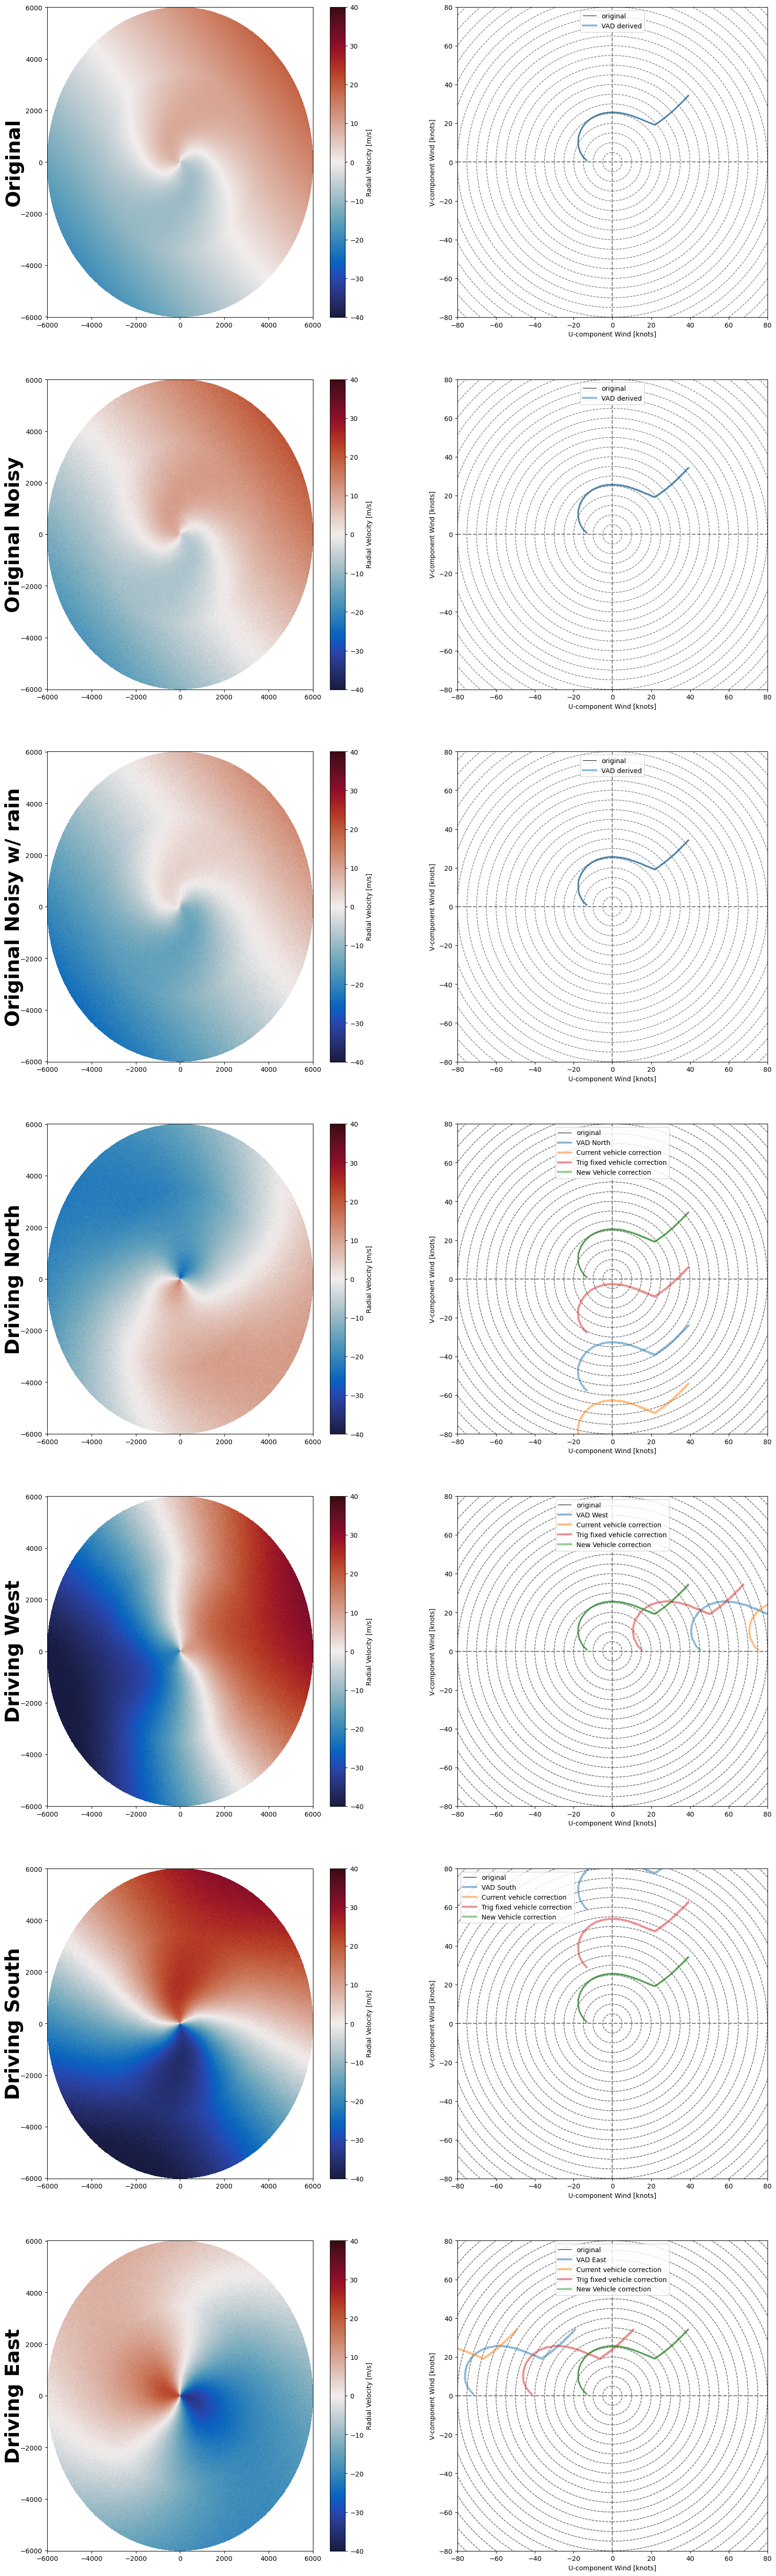

In [4]:
fig = plt.figure(figsize=(20, 70),facecolor='white')
ax1 = plt.subplot2grid((7,2),(0,0))
plt.pcolormesh(x_rad,y_rad,Vr,vmin=-40,vmax=40,cmap=cmocean.cm.balance)
plt.colorbar(label='Radial Velocity [m/s]')
ax1.text(-7500,0,'Original',weight='bold',rotation=90,fontsize=30,ha='center',va='center')

radar = pyart.testing.make_velocity_aliased_radar(alias=True)
radar.fixed_angle['data'] = np.array([45.0])
radar.azimuth['data']=az[::-1]+90
radar.elevation['data']=np.zeros_like(az)+45.0
radar.fields['reflectivity']['data'] = np.ma.array(np.zeros_like(R), mask = np.zeros_like(R))
radar.fields['velocity']['data'] = np.ma.array(Vr, mask = np.zeros_like(Vr))
radar.instrument_parameters['nyquist_velocity']['data'] = np.zeros_like(az)+100.0
radar.ngates = len(r)
radar.nrays = len(az)
radar.range['data'] = r
radar.sweep_end_ray_index['data'] = np.array([len(az)])
radar.time['data'] = np.arange(len(az))

ax2 = plt.subplot2grid((7,2),(0,1))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.plot(u[:201]*units('m/s').to('kts'),v[:201]*units('m/s').to('kts'),c='k',label='original',linewidth=0.75)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:blue',alpha=0.5,label='VAD derived',linewidth=3)
ax2.set_xlabel('U-component Wind [knots]')
ax2.set_ylabel('V-component Wind [knots]')
ax2.legend()

#############################################################################################################

ax1 = plt.subplot2grid((7,2),(1,0))
plt.pcolormesh(x_rad,y_rad,Vr_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)
plt.colorbar(label='Radial Velocity [m/s]')
ax1.text(-7500,0,'Original Noisy',weight='bold',rotation=90,fontsize=30,ha='center',va='center')

radar = pyart.testing.make_velocity_aliased_radar(alias=True)
radar.fixed_angle['data'] = np.array([45.0])
radar.azimuth['data']=az[::-1]+90
radar.elevation['data']=np.zeros_like(az)+45.0
radar.fields['reflectivity']['data'] = np.ma.array(np.zeros_like(R), mask = np.zeros_like(R))
radar.fields['velocity']['data'] = np.ma.array(Vr_noise, mask = np.zeros_like(Vr))
radar.instrument_parameters['nyquist_velocity']['data'] = np.zeros_like(az)+100.0
radar.ngates = len(r)
radar.nrays = len(az)
radar.range['data'] = r
radar.sweep_end_ray_index['data'] = np.array([len(az)])
radar.time['data'] = np.arange(len(az))


ax2 = plt.subplot2grid((7,2),(1,1))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.plot(u[:201]*units('m/s').to('kts'),v[:201]*units('m/s').to('kts'),c='k',label='original',linewidth=0.75)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:blue',alpha=0.5,label='VAD derived',linewidth=3)
ax2.set_xlabel('U-component Wind [knots]')
ax2.set_ylabel('V-component Wind [knots]')
ax2.legend()

#############################################################################################################

ax1 = plt.subplot2grid((7,2),(2,0))
plt.pcolormesh(x_rad,y_rad,Vr_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)
plt.colorbar(label='Radial Velocity [m/s]')
ax1.text(-7500,0,'Original Noisy w/ rain',weight='bold',rotation=90,fontsize=30,ha='center',va='center')

radar = pyart.testing.make_velocity_aliased_radar(alias=True)
radar.fixed_angle['data'] = np.array([45.0])
radar.azimuth['data']=az[::-1]+90
radar.elevation['data']=np.zeros_like(az)+45.0
radar.fields['reflectivity']['data'] = np.ma.array(np.zeros_like(R), mask = np.zeros_like(R))
radar.fields['velocity']['data'] = np.ma.array(Vr_precip_noise, mask = np.zeros_like(Vr))
radar.instrument_parameters['nyquist_velocity']['data'] = np.zeros_like(az)+100.0
radar.ngates = len(r)
radar.nrays = len(az)
radar.range['data'] = r
radar.sweep_end_ray_index['data'] = np.array([len(az)])
radar.time['data'] = np.arange(len(az))


ax2 = plt.subplot2grid((7,2),(2,1))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.plot(u[:201]*units('m/s').to('kts'),v[:201]*units('m/s').to('kts'),c='k',label='original',linewidth=0.75)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:blue',alpha=0.5,label='VAD derived',linewidth=3)
ax2.set_xlabel('U-component Wind [knots]')
ax2.set_ylabel('V-component Wind [knots]')
ax2.legend()

#############################################################################################################

ax1 = plt.subplot2grid((7,2),(3,0))
plt.pcolormesh(x_rad,y_rad,Vr_north_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)
plt.colorbar(label='Radial Velocity [m/s]')
ax1.text(-7500,0,'Driving North',weight='bold',rotation=90,fontsize=30,ha='center',va='center')

radar = pyart.testing.make_velocity_aliased_radar(alias=True)
radar.fixed_angle['data'] = np.array([45.0])
radar.azimuth['data']=az[::-1]+90
radar.elevation['data']=np.zeros_like(az)+45.0
radar.fields['reflectivity']['data'] = np.ma.array(np.zeros_like(R), mask = np.zeros_like(R))
radar.fields['velocity']['data'] = np.ma.array(Vr_north_precip_noise, mask = np.zeros_like(Vr))
radar.instrument_parameters['nyquist_velocity']['data'] = np.zeros_like(az)+100.0
radar.ngates = len(r)
radar.nrays = len(az)
radar.range['data'] = r
radar.sweep_end_ray_index['data'] = np.array([len(az)])
radar.time['data'] = np.arange(len(az))

ax2 = plt.subplot2grid((7,2),(3,1))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.plot(u[:201]*units('m/s').to('kts'),v[:201]*units('m/s').to('kts'),c='k',label='original',linewidth=0.75)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:blue',alpha=0.5,label='VAD North',linewidth=3)
hodo.plot(vadu,vadv-ground_vel,alpha=0.5,label='Current vehicle correction',linewidth=3,color='tab:orange')
hodo.plot(vadu,vadv+ground_vel,alpha=0.5,label='Trig fixed vehicle correction',linewidth=3,color='tab:red')

radar.fields['velocity']['data'] = radar.fields['velocity']['data']+(np.cos(np.deg2rad(az[::-1][:,np.newaxis]+90))*ground_vel)*np.cos(np.deg2rad(el))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:green',alpha=0.5,label='New Vehicle correction',linewidth=3)

ax2.set_xlabel('U-component Wind [knots]')
ax2.set_ylabel('V-component Wind [knots]')
ax2.legend()

#############################################################################################################

ax1 = plt.subplot2grid((7,2),(4,0))
plt.pcolormesh(x_rad,y_rad,Vr_west_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)
plt.colorbar(label='Radial Velocity [m/s]')
ax1.text(-7500,0,'Driving West',weight='bold',rotation=90,fontsize=30,ha='center',va='center')

radar = pyart.testing.make_velocity_aliased_radar(alias=True)
radar.fixed_angle['data'] = np.array([45.0])
radar.azimuth['data']=az[::-1]+90
radar.elevation['data']=np.zeros_like(az)+45.0
radar.fields['reflectivity']['data'] = np.ma.array(np.zeros_like(R), mask = np.zeros_like(R))
radar.fields['velocity']['data'] = np.ma.array(Vr_west_precip_noise, mask = np.zeros_like(Vr))
radar.instrument_parameters['nyquist_velocity']['data'] = np.zeros_like(az)+100.0
radar.ngates = len(r)
radar.nrays = len(az)
radar.range['data'] = r
radar.sweep_end_ray_index['data'] = np.array([len(az)])
radar.time['data'] = np.arange(len(az))

ax2 = plt.subplot2grid((7,2),(4,1))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.plot(u[:201]*units('m/s').to('kts'),v[:201]*units('m/s').to('kts'),c='k',label='original',linewidth=0.75)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:blue',alpha=0.5,label='VAD West',linewidth=3)
hodo.plot(vadu+ground_vel,vadv,alpha=0.5,label='Current vehicle correction',linewidth=3,color='tab:orange')
hodo.plot(vadu-ground_vel,vadv,alpha=0.5,label='Trig fixed vehicle correction',linewidth=3,color='tab:red')

radar.fields['velocity']['data'] = radar.fields['velocity']['data']+(np.cos(np.deg2rad(az[::-1][:,np.newaxis]+180))*ground_vel)*np.cos(np.deg2rad(el))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:green',alpha=0.5,label='New Vehicle correction',linewidth=3)

ax2.set_xlabel('U-component Wind [knots]')
ax2.set_ylabel('V-component Wind [knots]')
ax2.legend()

#############################################################################################################

ax1 = plt.subplot2grid((7,2),(5,0))
plt.pcolormesh(x_rad,y_rad,Vr_south_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)
plt.colorbar(label='Radial Velocity [m/s]')
ax1.text(-7500,0,'Driving South',weight='bold',rotation=90,fontsize=30,ha='center',va='center')

radar = pyart.testing.make_velocity_aliased_radar(alias=True)
radar.fixed_angle['data'] = np.array([45.0])
radar.azimuth['data']=az[::-1]+90
radar.elevation['data']=np.zeros_like(az)+45.0
radar.fields['reflectivity']['data'] = np.ma.array(np.zeros_like(R), mask = np.zeros_like(R))
radar.fields['velocity']['data'] = np.ma.array(Vr_south_precip_noise, mask = np.zeros_like(Vr))
radar.instrument_parameters['nyquist_velocity']['data'] = np.zeros_like(az)+100.0
radar.ngates = len(r)
radar.nrays = len(az)
radar.range['data'] = r
radar.sweep_end_ray_index['data'] = np.array([len(az)])
radar.time['data'] = np.arange(len(az))

ax2 = plt.subplot2grid((7,2),(5,1))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.plot(u[:201]*units('m/s').to('kts'),v[:201]*units('m/s').to('kts'),c='k',label='original',linewidth=0.75)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:blue',alpha=0.5,label='VAD South',linewidth=3)
hodo.plot(vadu,vadv+ground_vel,alpha=0.5,label='Current vehicle correction',linewidth=3,color='tab:orange')
hodo.plot(vadu,vadv-ground_vel,alpha=0.5,label='Trig fixed vehicle correction',linewidth=3,color='tab:red')

radar.fields['velocity']['data'] = radar.fields['velocity']['data']+(np.cos(np.deg2rad(az[::-1][:,np.newaxis]-90))*ground_vel)*np.cos(np.deg2rad(el))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:green',alpha=0.5,label='New Vehicle correction',linewidth=3)

ax2.set_xlabel('U-component Wind [knots]')
ax2.set_ylabel('V-component Wind [knots]')
ax2.legend()

#############################################################################################################

ax1 = plt.subplot2grid((7,2),(6,0))
plt.pcolormesh(x_rad,y_rad,Vr_east_precip_noise,vmin=-40,vmax=40,cmap=cmocean.cm.balance)
plt.colorbar(label='Radial Velocity [m/s]')
ax1.text(-7500,0,'Driving East',weight='bold',rotation=90,fontsize=30,ha='center',va='center')

radar = pyart.testing.make_velocity_aliased_radar(alias=True)
radar.fixed_angle['data'] = np.array([45.0])
radar.azimuth['data']=az[::-1]+90
radar.elevation['data']=np.zeros_like(az)+45.0
radar.fields['reflectivity']['data'] = np.ma.array(np.zeros_like(R), mask = np.zeros_like(R))
radar.fields['velocity']['data'] = np.ma.array(Vr_east_precip_noise, mask = np.zeros_like(Vr))
radar.instrument_parameters['nyquist_velocity']['data'] = np.zeros_like(az)+100.0
radar.ngates = len(r)
radar.nrays = len(az)
radar.range['data'] = r
radar.sweep_end_ray_index['data'] = np.array([len(az)])
radar.time['data'] = np.arange(len(az))

ax2 = plt.subplot2grid((7,2),(6,1))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.plot(u[:201]*units('m/s').to('kts'),v[:201]*units('m/s').to('kts'),c='k',label='original',linewidth=0.75)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:blue',alpha=0.5,label='VAD East',linewidth=3)
hodo.plot(vadu-ground_vel,vadv,alpha=0.5,label='Current vehicle correction',linewidth=3,color='tab:orange')
hodo.plot(vadu+ground_vel,vadv,alpha=0.5,label='Trig fixed vehicle correction',linewidth=3,color='tab:red')

radar.fields['velocity']['data'] = radar.fields['velocity']['data']+(np.cos(np.deg2rad(az[::-1][:,np.newaxis]))*ground_vel)*np.cos(np.deg2rad(el))
VAD = pyart.retrieve.vad_browning(radar, 'velocity', z_want=np.arange(0,6001,10),gatefilter=None)
vadu = VAD.u_wind*units('m/s').to('kts')
vadv = VAD.v_wind*units('m/s').to('kts')
hodo = metpy.plots.Hodograph(ax2,component_range=80.)
hodo.add_grid(increment=5)
hodo.plot(vadu,vadv,c='tab:green',alpha=0.5,label='New Vehicle correction',linewidth=3)

ax2.set_xlabel('U-component Wind [knots]')
ax2.set_ylabel('V-component Wind [knots]')
ax2.legend()